## Simulation Design 
###  Based on the code of EIP-1559 valuation system from last semester
- When an NFT drops, large amounts of transactions suddenly flood into the mempool with much higher valuations. 
- increase a lump of txs into the mempool at 25th block (start point) 
- increase value and gas_limit -- n size larger 
- back to normal


# Congestion Simulation

We simulate the ethereum market in both the status quo and under EIP-1559. Both simulations draw from the same distribution of "values", which quantify the amount that users inherently value their transaction. Both simulations also draw from the same "gas used" distributions.

We first import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import math
from collections import deque
import matplotlib.pyplot as plt
import cProfile
import random

Throughout the simulation, we keep track of blocks filled and oracle prediction values generated. 

In [2]:
sq_current_oracle = 0
eip_current_oracle = 0 

sq_blocks = []
eip_blocks = []

sq_block_mins =  deque([])
eip_block_mins = deque([])

sq_gas_price_batches = []
eip_gas_price_batches = []

sq_wait_times =[]
eip_wait_times=[]

At every iteration of the simulation, a block is filled with the most lucrative transactions in the mempool, and the mempool is filled again with 2000 transactions. In the function defined below, 2000 samples are taken from the "values" and "gas used" distributions, price mapped to Status Quo and EIP-1559 simulations, and added to the existing mempool. 

In [3]:
def create_mempool(txn_number, sq_df, eip_df, basefee,gas_congestion_size, price_congestion_size, t=0):
  
    global sq_current_oracle, eip_current_oracle, sq_gas_price_batches, eip_gas_price_batches

    ## adjust values and gas_limit with price_congestion_size and gas_congestion_size 
    ## based on the post-eip data -- n times lager than the regular biddings
    values = np.random.gamma(20.72054, 1/17.49951, txn_number) * price_congestion_size
    # values = [x * random.randint(1, price_congestion_size) for x in values]
    gas_limit = (np.random.pareto(1.42150, txn_number)+1)*21000* gas_congestion_size   # pareto distribution with alpha 1.42150, beta 21000
     
    
    sq_gas_prices = [sq_current_oracle * v for v in values] 
    eip_gas_prices = [min(basefee + (eip_current_oracle * v), sq_current_oracle * v) for v in values]   
    
    eip_gas_price_batches += [eip_gas_prices]
    sq_gas_price_batches += [sq_gas_prices]
    
    # store each updated mempool as a DataFrame

    sq_df = sq_df.append(pd.DataFrame({
        'gas price': sq_gas_prices,
        'gas limit': gas_limit,
        'time' : t,
        'amount paid': [x * y for x,y in zip(sq_gas_prices,gas_limit)]
        }), ignore_index=True)
    

    eip_df = eip_df.append(pd.DataFrame({
        'gas price': eip_gas_prices,
        'gas limit': gas_limit,
        'time': t,
        'amount paid' : [x * y for x,y in zip(eip_gas_prices,gas_limit)]
        }), ignore_index=True)
    
    # sort transactions in each mempool by gas price
    
    sq_df = sq_df.sort_values(by=['gas price'], ascending=False).reset_index(drop=True)
    eip_df = eip_df.sort_values(by=['gas price'], ascending=False).reset_index(drop=True)
    
    return sq_df, eip_df

We define some helper functions. First, a function to calculate a new basefee. Second, a function to update the oracle values for each transaction. We create a sorted list of the smallest (lowest gas-price) transactions from the previous hundred blocks. The oracle value is defined as the 60th item in that list. Finally, we need functions to fill blocks for both simulations. Because the protocols have different rules on this, we pass a basefee of 0 in the Status Quo simulation and pass in the actual basefee in the EIP-1559 simulation. 

In [4]:
def get_basefee(b, g): 
    print(b)
    return b*(1+(1/8)*((g-15000000)/15000000))

def get_oracle():
    
    global sq_current_oracle, sq_block_mins, sq_blocks, eip_block_mins, eip_current_oracle, eip_blocks
    
    #sq_current_oracle = update_oracle(sq_current_oracle, sq_block_mins, sq_blocks)
    eip_current_oracle = update_oracle(eip_current_oracle, eip_block_mins, eip_blocks)

def update_oracle(current_oracle, block_minimums, blocks):
    if len(blocks[-1]) == 0:
        recent_gp = 0
    else:
        recent_gp = blocks[-1][-1][0]
    block_minimums.popleft()
    block_minimums.append(recent_gp)

    sorted_block_minimums = sorted(block_minimums)
  
    return sorted_block_minimums[59]

def fill_block(mempool, basefee, time):
    global eip_wait_times, sq_wait_times
    
    block = []
    block_size = 0
    block_limit = 30000000 if basefee > 0 else 15000000
    
    for i in range(len(mempool)):
        txn = mempool.iloc[i, :].tolist()
        if block_size + txn[1] > block_limit or txn[0] < basefee:
            # print(txn[0] < basefee, txn[0], basefee)
            break
        else:
            block.append(txn)
            block_size += txn[1]
    
    block_wait_times = [time - txn[2] for txn in block]
    if basefee:
        eip_wait_times.append(block_wait_times)
    else:
        sq_wait_times.append(block_wait_times)
    
    #remove verified txns from mempool
    mempool = mempool.iloc[i+1:,:]    
    return block, mempool, block_size

New added function -- The single spike simulation is ran in the following function, storing data on each iteration. 

In [6]:
def pending_tx_sizes(n):
    number_of_spikes = 1    
    
    values = [None for _ in range(n)]  # n values of None 
    price_congestion = [1 for _ in range(n)]
    gas_congestion = [1 for _ in range(n)]
    
    
    for i in range(n):   
        if values[i] == None:
            values[i] = random.randint(100, 400)
    values[25] = random.randint(5000,15000)
    price_congestion[25]= random.randint(10,80)
    gas_congestion[25] = random.uniform(1.5,2)
    
    
    return values, gas_congestion, price_congestion

In [7]:
def simulate(n):
    
    #initialize empty dataframes
    df1 = pd.DataFrame() 
    df2 = pd.DataFrame() 
    
    sq_block_data = pd.DataFrame()
    eip_block_data = pd.DataFrame()
   
    sq_mempool_data = pd.DataFrame()
    eip_mempool_data = pd.DataFrame()
    
  
    sq_mempools = []
    eip_mempools = []
    eip_mempools_bf = []
    demands = []
    
    global sq_block_mins, eip_block_mins, sq_blocks, sq_current_oracle, eip_current_oracle, eip_blocks, eip_wait_times, sq_wait_times
    
    #read in data to initialize oracle
    data = pd.read_csv('block_data.csv')
    minGasdf = data[['gasLimit','minGasPrice']].values 
    for d in minGasdf:
        if len(eip_block_mins) == 100:
            break
        if d[1] == 'None':
            continue
        sq_block_mins.append(int(d[1]) / 10**9)
        eip_block_mins.append(int(d[1]) / 10**9)
    
    basefee = eip_block_mins[-1]
    basefees = [basefee]
    
    sorted_sq_block_mins = sorted(sq_block_mins)
    sorted_eip_block_mins = sorted([x - basefee if x >= basefee else 0 for x in eip_block_mins])
    
    #set initial oracles
    sq_current_oracle = sorted_sq_block_mins[59]
    eip_current_oracle = sorted_eip_block_mins[59]
    
    #initialize mempools with 700 txns
    sq_mempool, eip_mempool = create_mempool(8500, df1, df2, basefee,1,1)
    
    
    new_txs_sizes, gas_congestions, price_congestions = pending_tx_sizes(n)
    
    #iterate over n blocks
    for i in range(n):
        
        #fill blocks from mempools
        new_eip_block, new_eip_mempool, eip_blocksize = fill_block(eip_mempool, basefee, i)
        new_sq_block, new_sq_mempool, sq_blocksize = fill_block(sq_mempool, 0, i)
        
        sq_blocks += [new_sq_block]
        eip_blocks += [new_eip_block]
        
        get_oracle()
        
        #update mempools
        sq_mempool = new_sq_mempool
        eip_mempool = new_eip_mempool
        basefee = get_basefee(basefee, eip_blocksize)
        basefees += [basefee]
        
#        sq_mempools += [sq_mempool]
#        eip_mempools += [eip_mempool]
#        eip_mempools_bf += [eip_mempool[eip_mempool['gas price'] >= basefee]]
        
        #add 200 new txns before next iteration
        new_demand = new_txs_sizes[i]
        price_congestion = price_congestions[i]
        gas_congestion = gas_congestions[i]
        sq_mempool, eip_mempool = create_mempool(new_demand, sq_mempool, eip_mempool, basefee, gas_congestion, price_congestion, i+1) #randomly select from 50 to 400
        
        demands += [new_demand]
        
        print("progress: ", i+1, end = '\r')
    return basefees, eip_blocks, sq_blocks, eip_mempools, sq_mempools, eip_mempools_bf, demands, eip_wait_times, sq_wait_times

We run the simulation and save/print the summary data.

In [8]:
s = simulate(200)
basefees_data = s[0]
eip_blocks_data = s[1]
sq_blocks_data = s[2]
eip_mempools_data = s[3]
sq_mempools_data = s[4]
eip_mempools_bf_data = s[5]
demands = s[6]
eip_wait_times = s[7]
sq_wait_times = s[8]

# cProfile.run("simulate(100)")

1
38.100002694
42.808852397179535
39.862807704078
40.06879112860958
36.5821988639041
36.53570709222588
41.089315958651696
38.563202909806755
39.55178805410593
37.3754980615368
42.04417397615185
39.07637788377958
41.14301434995392
39.64865302911564
36.39351672070784
40.93695057679429
38.75666441116939
36.140956252370465
40.618200260220966
42.1021162435849
41.64561857339778
38.81518384436938
39.41241936414439
37.649327939725644
42.348784216246095
39.15886760026447
41.38994456996593
46.55082486560681
52.3187873290433
55.469177248004954
61.934326983838034
69.67481783204997
78.36200966050535
88.10255784314909
99.09999588298007
111.47324750201793
125.31719523621514
140.97041637289144
158.554829389708
171.01731651494825
192.33617499984902
216.12116404862147
243.06986710233656
273.2798857356977
265.74677248221843
297.7092332218006
334.3714123788435
361.1448959280836
406.21568549272
456.92835762536185
486.38109248438053
425.58345592383296
372.38552393335385
325.8373334416846
285.10766676147404


In [9]:
(print(True in [len(x) == 0 for x in sq_mempools_data]))

False


# Basefee Over Time:

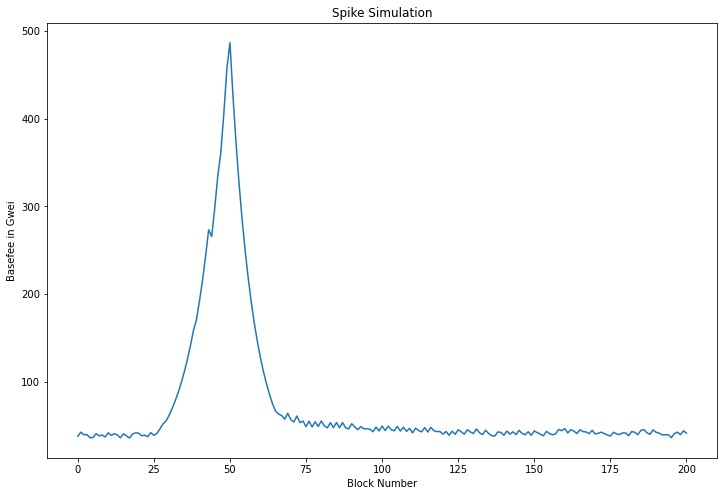

In [10]:
plt.rcParams["figure.figsize"] = (12,8)
plt.title("Spike Simulation")
plt.xlabel("Block Number")
plt.ylabel("Basefee in Gwei")
plt.plot(basefees_data);